# Classification Plot

Example based on the upstream code in `classification_plots`.

In [1]:
%matplotlib inline
from __future__ import print_function, division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from glob import glob

# temporary for seaborn/matplotlib: hist() param deprecation
import warnings
warnings.simplefilter("ignore")

Output classification summary file. Note that these were not well formed tsv as the tabs were duplicated to force alignment.

In [2]:
input_glob = '../tests/refout/classification_overview.txt*'
!head {input_glob}

IC	Motion/noise	maximum RP correlation	Edge-fraction		High-frequency content	CSF-fraction
1	False		0.71			0.22			0.14			0.00
2	False		0.69			0.16			0.19			0.00
3	False		0.69			0.44			0.16			0.00
4	False		0.69			0.36			0.20			0.02
5	False		0.71			0.48			0.12			0.00
6	False		0.69			0.24			0.18			0.00
7	False		0.67			0.18			0.20			0.01
8	False		0.70			0.47			0.20			0.03
9	False		0.67			0.37			0.21			0.00


Read the file into a pandas DataFrame and simplify the column labels as they have embedded spaces etc.

In [3]:
fnames = glob(input_glob)

cols = [1, 2, 3, 4, 5]
colnames = ['Motion', 'RP', 'Edge', 'Freq', 'CSF']

dfs = [pd.read_csv(fname, delim_whitespace=True, skiprows=1, usecols=cols, names=colnames) for fname in fnames]
df = pd.concat(dfs, ignore_index=True)

dummy_true_df = pd.DataFrame.from_records([[True, 1.0, 1.0, 0.0, 0.0]] * 3, columns=colnames)
dummy_false_df = pd.DataFrame.from_records([[False, 0.0, 0.0, 0.0, 0.0]] * 3, columns=colnames)
    
# Get counts
ncomponents, nmotion = len(df), sum(df['Motion'])
print('Found', nmotion, 'head motion-related components in a total of', ncomponents, 'components.')

# Add dummy components if needed - this is just for making the plots look nice.
if not any(df['Motion']):
    df = df.append(dummy_true_df, ignore_index=True)
if not any(~df['Motion']):
    df = df.append(dummy_false_df, ignore_index=True)

df.head()

Found 19 head motion-related components in a total of 45 components.


,Motion,RP,Edge,Freq,CSF
0,False,0.71,0.22,0.14,0.00
1,False,0.69,0.16,0.19,0.00
2,False,0.69,0.44,0.16,0.00
3,False,0.69,0.36,0.20,0.02
4,False,0.71,0.48,0.12,0.00


Produce the plot. Note that the projection line is hard coded here.

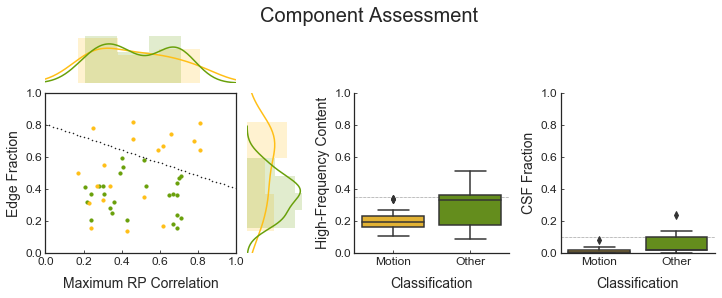

In [4]:
# Make pretty figure styling
sns.set_style('white')
colour_true = '#FFBF17'
colour_false = '#69A00A'

# Figure
fig = plt.figure(figsize=[12, 4])

# Grids
gs = gridspec.GridSpec(4, 7, wspace=1)
gs00 = gridspec.GridSpecFromSubplotSpec(4, 4, subplot_spec=gs[:, 0:3])
gs01 = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs[:, 3:5])
gs02 = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs[:, 5:7])

# Subplots

# Edge/RP
ax1 = fig.add_subplot(gs00[1:4, 0:3])
# Distribution of Edge Fraction (ax1 top)
ax1t = fig.add_subplot(gs00[0, 0:3])
# Distribution of RP Correlation (ax1 right)
ax1r = fig.add_subplot(gs00[1:4, 3])
# High Frequency Content
ax2 = fig.add_subplot(gs01[1:4, :])
# CSF Fraction
ax3 = fig.add_subplot(gs02[1:4, :])

axs = [ax1, ax1t, ax1r, ax2, ax3]

#
# Plot Edge/RP relationship
#

# Projection line
hyp = [-19.9751070082159, 9.95127547670627, 24.8333160239175]
a = -hyp[1] / hyp[2]
xx = np.linspace(0, 1)
yy = a * xx - hyp[0] / hyp[2]

# Plot scatter and line
marker_size = 10 if len(df) <= 100 else 6
ax1.scatter(
    x='RP', y='Edge',
    data=df.loc[~df['Motion']],
    color=colour_false,
    s=marker_size
)

# Plot True ones on top to see how much the go over the border
# this gives an indication for how many were selected using the
# two other features
ax1.scatter(
    x='RP', y='Edge',
    data=df.loc[df['Motion']],
    color=colour_true,
    s=marker_size
)

# Add the decision boundary
ax1.plot(xx, yy, '.', color='k', markersize=1)

# Styling
ax1.set_ylim([0, 1])
ax1.set_xlim([0, 1])
ax1.set_xlabel('Maximum RP Correlation', fontsize=14, labelpad=10)
ax1.set_ylabel('Edge Fraction', fontsize=14)
ax1.set_xticks(np.arange(0, 1.2, 0.2))
ax1.set_yticks(np.arange(0, 1.2, 0.2))
ax1.tick_params(axis='both', labelsize=12)

# Plot distributions
# RP
sns.distplot(
    df.loc[df['Motion'], 'RP'],
    ax=ax1t,
    color=colour_true,
    hist_kws={'alpha': 0.2}
)
sns.distplot(
    df.loc[~df['Motion'], 'RP'],
    ax=ax1t,
    color=colour_false,
    hist_kws={'alpha': 0.2}
)
ax1t.set_xlim([0, 1])

# Edge Fraction
sns.distplot(
    df.loc[df['Motion'], 'Edge'],
    ax=ax1r,
    vertical=True,
    color=colour_true,
    hist_kws={'alpha': 0.2}
)
sns.distplot(
    df.loc[~df['Motion'], 'Edge'],
    ax=ax1r,
    vertical=True,
    color=colour_false,
    hist_kws={'alpha': 0.2}
)
ax1r.set_ylim([0, 1])

# Cosmetic settings for distribution plots
for ax in [ax1t, ax1r]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    for side in ['right', 'top', 'bottom', 'left']:
        ax.spines[side].set_visible(False)

# Plot HF Fraction Classifier
sns.boxplot(
    x='Motion', y='Freq',
    data=df,
    ax=ax2,
    palette=[colour_true, colour_false]
)
ax2.hlines(0.35, -1, 2, zorder=0, linestyles='dotted', linewidth=0.5)
ax2.set_ylim([0, 1])
ax2.set_xlabel('Classification', fontsize=14, labelpad=10)
ax2.set_ylabel('High-Frequency Content', fontsize=14)
ax2.set_xticklabels(['Motion', 'Other'])
ax2.tick_params(axis='both', labelsize=12)
sns.despine(ax=ax2)

# Plot CSF Fraction Classifier
sns.boxplot(
    x='Motion', y='CSF',
    data=df,
    ax=ax3,
    palette=[colour_true, colour_false]
)
ax3.hlines(0.1, -1, 2, zorder=0, linestyles='dotted', linewidth=0.5)
ax3.set_ylim([0, 1])
ax3.set_xlabel('Classification', fontsize=14, labelpad=10)
ax3.set_ylabel('CSF Fraction', fontsize=14)
ax3.set_xticklabels(['Motion', 'Other'])
ax3.tick_params(axis='both', labelsize=12)
sns.despine(ax=ax3)

# Bring tickmarks back on all plots
for ax in axs:
    ax.tick_params(which='major', direction='in', length=3)

# Add figure title
plt.suptitle('Component Assessment', fontsize=20);